In [ ]:
import os
if not os.path.exists('exchange_rate_analysis'):
    !git clone https://github.com/matthewhirokawa/exchange_rate_analysis.git
%cd exchange_rate_analysis

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import datetime
import spacy
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model  import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from collections import defaultdict
import en_core_web_md

In [42]:
usa_china_df_extended = pd.read_csv('data/usa_china_text_data_2021.csv', dtype = {'Date': str})
usa_china_df_extended = usa_china_df_extended.dropna(subset=['Content'])
usa_china_df_extended['Date'] = pd.to_datetime(usa_china_df_extended['Date'], format='%d%m%y')
usa_china_df_extended['Month'] = usa_china_df_extended['Date'].dt.to_period('M')
usa_china_df_extended.head()

,Date,Title,Content,Source,Month
0,2025-07-12,On the 9th Anniversary of the Philippines-Chin...,"Nine years ago, an Arbitral Tribunal constitut...",USA,2025-07
1,2025-07-11,Secretary of State Marco Rubio Remarks to the ...,SECRETARY RUBIO: We had a great visit – great ...,USA,2025-07
2,2025-07-11,Secretary of State Marco Rubio Remarks to the ...,SECRETARY RUBIO: You guys don’t look nearly a...,USA,2025-07
3,2025-07-11,Secretary Rubio’s Meeting with China’s Directo...,The below is attributable to Spokesperson Tamm...,USA,2025-07
4,2025-07-08,"Department Press Briefing – July 8, 2025",QUESTION: On – there was this press conference...,USA,2025-07


In [43]:
from spacy.lang.en import English
en = English()
n = 10

def simple_tokenizer(doc, model=en):
    tokenized_docs = []
    parsed = model(doc)
    return([t.lower_ for t in parsed if (t.is_alpha)&(not t.like_url)&(not t.is_stop)])

#TF-IDF Vectorization with unigrams
tfidf_text_content = TfidfVectorizer(tokenizer = simple_tokenizer, token_pattern = None, ngram_range=(1,1))

tfidf_text_content_vecs = tfidf_text_content.fit_transform(usa_china_df_extended['Content']).toarray()
#returns filter names identified by TF-IDF vectorizer
#filter so that the source is USA or China articles
#creates dictionary for top words and their TF-IDF score
tfidf_count_text_content_usa_to_china = dict(zip(tfidf_text_content.get_feature_names_out(), tfidf_text_content_vecs[usa_china_df_extended['Source'] == 'USA'].sum(axis = 0)))
tfidf_count_text_content_china_to_usa = dict(zip(tfidf_text_content.get_feature_names_out(), tfidf_text_content_vecs[usa_china_df_extended['Source'] == 'China'].sum(axis = 0)))

tfidf_dicts = {'USA-China': tfidf_count_text_content_usa_to_china,
              'China-USA': tfidf_count_text_content_china_to_usa}


In [44]:
#Get sentiment of words from dictionaries
#Use opinion lexicon from NLTK, Natural Language Toolkit, identifies words as positive or negative

#potential issues: all are weighted the same, no difference between very negative/slightly negative, etc.

from nltk.corpus import opinion_lexicon
from nltk.sentiment.util import mark_negation
from nltk.corpus import sentiwordnet as swn
import nltk
nltk.download('opinion_lexicon')

#get words that are positive or negative
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

#pass in TF-IDF dictionaries and calculate overall sentiment
#returns between -1 and 1, negative to positive
def compute_overall_sentiment(tfidf_dict):
    total_score = 0
    total_weight = 0
    for word, tfidf_score in tfidf_dict.items():
        if word in positive_words:
            sentiment = 1  #positive
        elif word in negative_words:
            sentiment = -1  #negative
        else:
            sentiment = 0  #unknown

        total_score += tfidf_score * sentiment
        total_weight += tfidf_score

    overall_sentiment = total_score / total_weight
    return overall_sentiment

#get overall bilateral sentiment
pairs_to_combine = [('USA-China', 'China-USA')]
bilateral_sentiment_scores_nltk = {}

for country_a, country_b in pairs_to_combine:
    #pass in country relationship, e.g. USA-China for country_a, call function to compute one way sentiment on dictionary
    #that corresponds to country_a, e.g. call on key USA-China
    score_a = compute_overall_sentiment(tfidf_dicts[country_a])
    score_b = compute_overall_sentiment(tfidf_dicts[country_b])
    
    combined_score = (score_a + score_b) / 2
    
    #relation_name = f"{country_a.split('-')[0]}-{country_a.split('-')[1]}"
    relation_name = country_a
    bilateral_sentiment_scores_nltk[relation_name] = combined_score

print('')
print('Bilateral sentiment scores (NLTK):')
print(bilateral_sentiment_scores_nltk)


Bilateral sentiment scores (NLTK):
{'USA-China': 0.016377884277476242}


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/matthewhirokawa/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [45]:
#robustness check on sentiment value by using TextBlob instead of NLTK 
#TextBlob handles extremity of words, more negative for more hostile, more positive for more friendly
#NLTK only assigns -1, 0, 1
#TextBlob has larger vocabulary
from textblob import TextBlob

#adjust previously defined function to use TextBlob
def compute_overall_sentiment_textblob(tfidf_dict):
    total_score = 0
    total_weight = 0
    for word, tfidf_score in tfidf_dict.items():
        
        #get sentimentfor the single word and weight by TF-IDF value
        sentiment = TextBlob(word).sentiment.polarity
        
        total_score += tfidf_score * sentiment
        total_weight += tfidf_score
    
    if total_weight == 0:
        return 0  # or np.nan if you prefer
    
    overall_sentiment = total_score / total_weight
    return overall_sentiment

bilateral_sentiment_scores_textblob = {}

for country_a, country_b in pairs_to_combine:
    #pass in country relationship, e.g. USA-China for country_a, call function to compute one way sentiment on dictionary
    #that corresponds to country_a, e.g. call on key USA-China
    score_a = compute_overall_sentiment_textblob(tfidf_dicts[country_a])
    score_b = compute_overall_sentiment_textblob(tfidf_dicts[country_b])
    
    combined_score = (score_a + score_b) / 2
    
    #relation_name = f"{country_a.split('-')[0]}-{country_a.split('-')[1]}"
    relation_name = country_a
    bilateral_sentiment_scores_textblob[relation_name] = combined_score

print('Bilateral sentiment scores (TextBlob):')
print(bilateral_sentiment_scores_textblob)

Bilateral sentiment scores (TextBlob):
{'USA-China': 0.010567415030727206}


In [46]:
#get monthly tfidf values for each country relationship (one way)
def compute_monthly_tfidf_dict(df, tokenizer):
    monthly_tfidf = {}
    for month, group in df.groupby('Month'):
        #drop NaNs, grouped by month
        texts = group['Content'].dropna().tolist()
        if not texts:
            continue

        #use tf-idf vectorizer
        vectorizer = TfidfVectorizer(tokenizer = simple_tokenizer, token_pattern = None, ngram_range=(1,1))
        tfidf_matrix = vectorizer.fit_transform(texts)
        feature_names = vectorizer.get_feature_names_out()   #get words
        tfidf_sum = tfidf_matrix.sum(axis=0)   #sum across all documents per month

        #create dictionary to store words and their tf-idf values
        tfidf_dict = {feature_names[i]: tfidf_sum[0, i] for i in range(len(feature_names))}
        monthly_tfidf[month] = tfidf_dict
    return monthly_tfidf

#compute monthly tfidf values
usa_china_tfidf = compute_monthly_tfidf_dict(usa_china_df_extended, simple_tokenizer)
china_usa_tfidf = compute_monthly_tfidf_dict(usa_china_df_extended, simple_tokenizer)

relations = [('USA-China', usa_china_tfidf, china_usa_tfidf)]

In [47]:
#get monthly bilateral sentiment
monthly_bilateral_sentiment_nltk = defaultdict(dict)  # {month: {pair_name: score}}

for pair_name, tfidf_a, tfidf_b in relations:
    all_months = set(tfidf_a.keys()).union(set(tfidf_b.keys()))

    #compute sentiment by month, convert to bilateral sentiment by averaging
    for month in sorted(all_months):
        dict_a = tfidf_a.get(month)
        dict_b = tfidf_b.get(month)

        score_a = compute_overall_sentiment(dict_a) if dict_a else None
        score_b = compute_overall_sentiment(dict_b) if dict_b else None

        #checks case where one way sentiment does not exist for a country
        if score_a is not None and score_b is not None:
            combined_score = (score_a + score_b) / 2
        elif score_a is not None:
            combined_score = score_a
        elif score_b is not None:
            combined_score = score_b
        else:
            continue  # no data

        monthly_bilateral_sentiment_nltk[month][pair_name] = combined_score

#save as csv
rows = []
#loop on each month and dictionary of relations and monthly tf-idf value
for month, scores_dict in monthly_bilateral_sentiment_nltk.items():
    #loop on relation and get score for month
    for pair, score in scores_dict.items():
        rows.append({'Month': month, 'Relation': pair, 'Sentiment': score})

monthly_sentiment_df_nltk = pd.DataFrame(rows)
monthly_sentiment_df_nltk = monthly_sentiment_df_nltk.sort_values(['Month', 'Relation']).reset_index(drop = True)
#monthly_sentiment_df_nltk.to_csv("usa_china_extended_monthly_sentiment_nltk.csv", index = False)


#monthly bilateral sentiment with TextBlob
monthly_bilateral_sentiment_textblob = defaultdict(dict)  # {month: {pair_name: score}}
#get monthly bilateral sentiment
for pair_name, tfidf_a, tfidf_b in relations:
    all_months = set(tfidf_a.keys()).union(set(tfidf_b.keys()))

    #compute sentiment by month, convert to bilateral sentiment by averaging
    for month in sorted(all_months):
        dict_a = tfidf_a.get(month)
        dict_b = tfidf_b.get(month)

        score_a = compute_overall_sentiment_textblob(dict_a) if dict_a else None
        score_b = compute_overall_sentiment_textblob(dict_b) if dict_b else None

        #checks case where one way sentiment does not exist for a country
        if score_a is not None and score_b is not None:
            combined_score = (score_a + score_b) / 2
        elif score_a is not None:
            combined_score = score_a
        elif score_b is not None:
            combined_score = score_b
        else:
            continue  # no data

        monthly_bilateral_sentiment_textblob[month][pair_name] = combined_score

#save as csv
rows = []
#loop on each month and dictionary of relations and monthly tf-idf value
for month, scores_dict in monthly_bilateral_sentiment_textblob.items():
    #loop on relation and get score for month
    for pair, score in scores_dict.items():
        rows.append({'Month': month, 'Relation': pair, 'Sentiment': score})

monthly_sentiment_df_textblob = pd.DataFrame(rows)
monthly_sentiment_df_textblob = monthly_sentiment_df_textblob.sort_values(['Month', 'Relation']).reset_index(drop = True)
#monthly_sentiment_df_textblob.to_csv("usa_china_extended_monthly_sentiment_textblob.csv", index = False)

In [64]:
#read in data from CSVs
monthly_sentiment_nltk = pd.read_csv('data/usa_china_extended_monthly_sentiment_nltk.csv')
#monthly_sentiment_nltk['Month'] = pd.to_datetime(monthly_sentiment_nltk['Month'])

monthly_sentiment_textblob = pd.read_csv('data/usa_china_extended_monthly_sentiment_textblob.csv')
#monthly_sentiment_textblob['Month'] = pd.to_datetime(monthly_sentiment_textblob['Month'])

usd_cny_exchange_rate = pd.read_csv('data/usd_cny_monthly_exchange_rate_2021.csv')

<class 'str'>


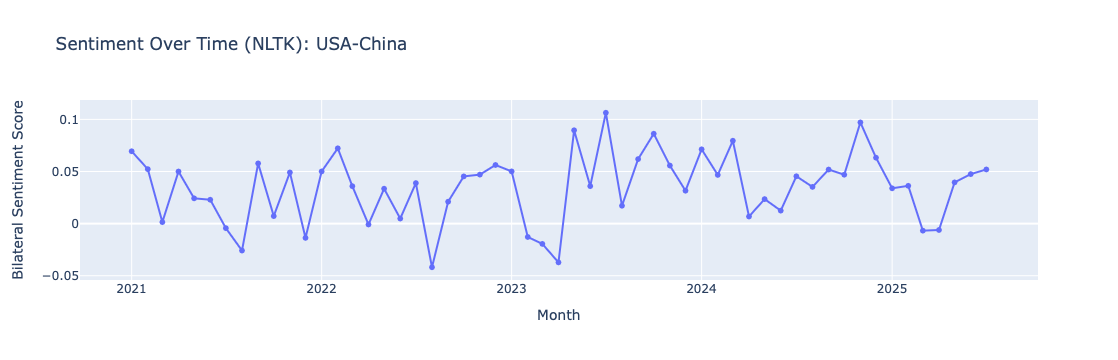

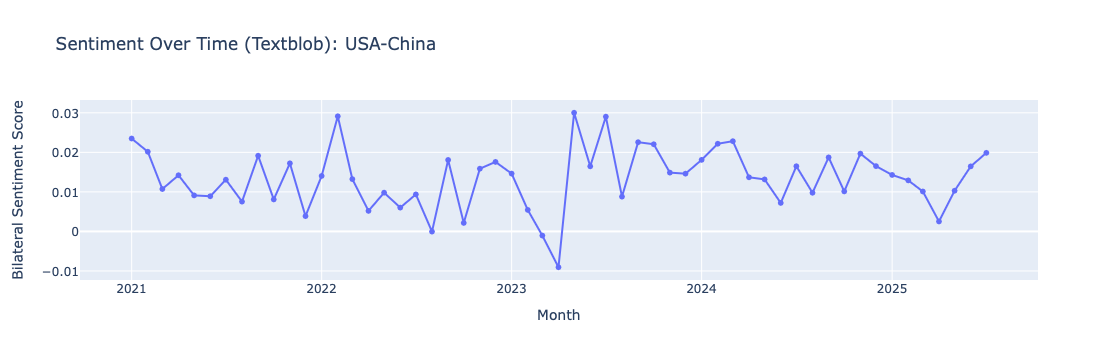

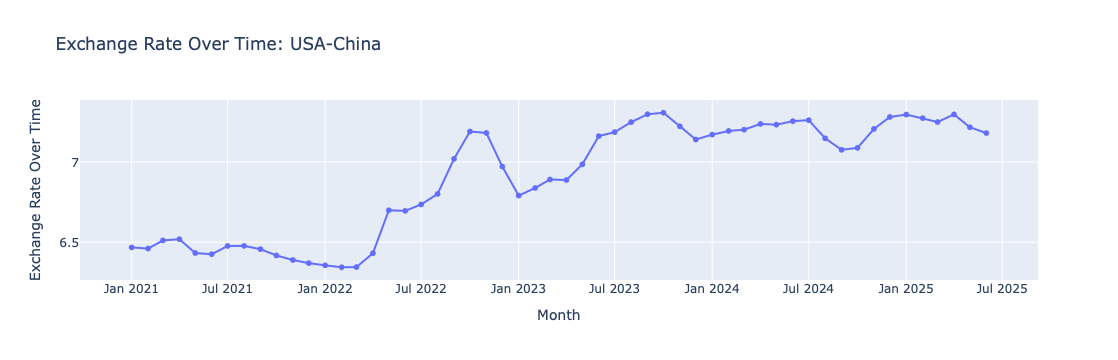

In [49]:
#nltk
relation = 'USA-China'
fig = px.line(monthly_sentiment_nltk, x = 'Month', y = 'Sentiment', title = f'Sentiment Over Time (NLTK): {relation}', markers = True)
fig.update_layout(xaxis_title = 'Month', yaxis_title = 'Bilateral Sentiment Score', hovermode = 'x unified')
fig.show()
#textblob
fig = px.line(monthly_sentiment_textblob, x = 'Month', y = 'Sentiment', title = f'Sentiment Over Time (Textblob): {relation}', markers = True)
fig.update_layout(xaxis_title = 'Month', yaxis_title = 'Bilateral Sentiment Score', hovermode = 'x unified')
fig.show()

fig = px.line(usd_cny_exchange_rate, x = 'Month', y = 'EXCHUS', title = f'Exchange Rate Over Time: {relation}', markers = True)
fig.update_layout(xaxis_title = 'Month', yaxis_title = 'Exchange Rate Over Time', hovermode = 'x unified')
fig.show()

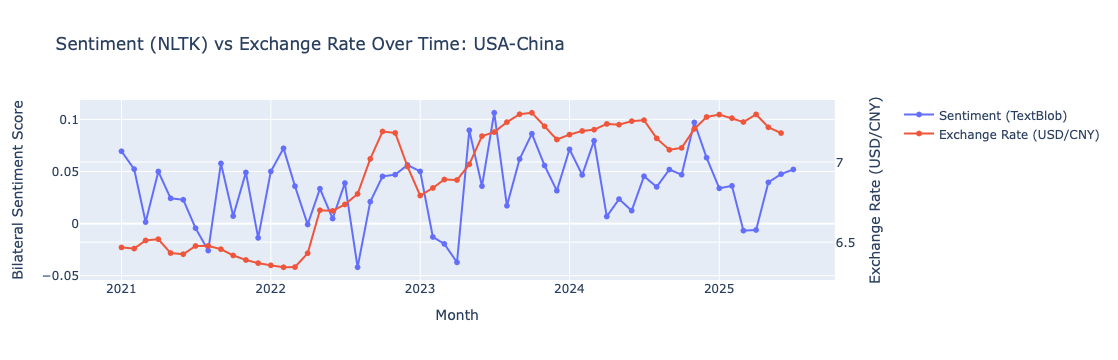

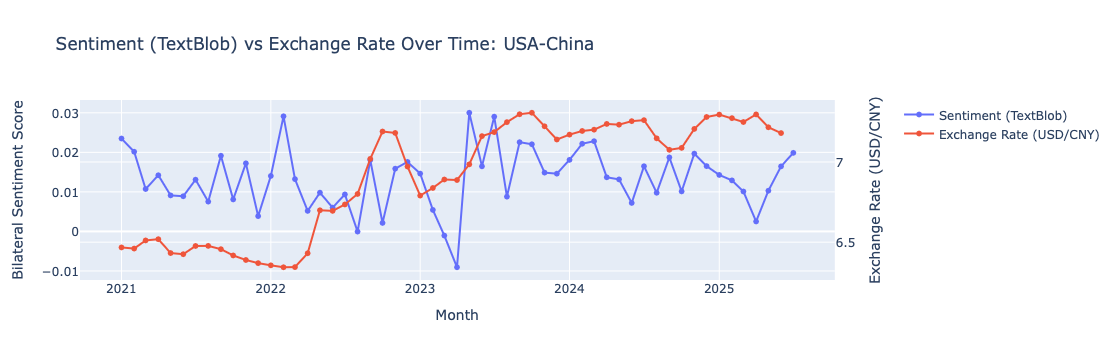

In [50]:
#show graphs joined by month on x axis
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Create a figure with secondary y-axis
#NLTK
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add Sentiment trace (primary y-axis)
fig.add_trace(go.Scatter(x = monthly_sentiment_nltk['Month'], y = monthly_sentiment_nltk['Sentiment'], name = 'Sentiment (TextBlob)',
            mode = 'lines+markers'), secondary_y = False)

# Add Exchange Rate trace (secondary y-axis)
fig.add_trace(go.Scatter(x = usd_cny_exchange_rate['Month'], y = usd_cny_exchange_rate['EXCHUS'], name = 'Exchange Rate (USD/CNY)',
        mode = 'lines+markers'), secondary_y = True)

# Update layout
fig.update_layout(title_text = f'Sentiment (NLTK) vs Exchange Rate Over Time: {relation}',hovermode = 'x unified')

# Set axis titles
fig.update_xaxes(title_text = 'Month')
fig.update_yaxes(title_text = 'Bilateral Sentiment Score', secondary_y = False)
fig.update_yaxes(title_text = 'Exchange Rate (USD/CNY)', secondary_y = True)

# Show plot
fig.show()

#TextBlob
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add Sentiment trace (primary y-axis)
fig.add_trace(go.Scatter(x = monthly_sentiment_textblob['Month'], y = monthly_sentiment_textblob['Sentiment'], name = 'Sentiment (TextBlob)',
            mode = 'lines+markers'), secondary_y = False)

# Add Exchange Rate trace (secondary y-axis)
fig.add_trace(go.Scatter(x = usd_cny_exchange_rate['Month'], y = usd_cny_exchange_rate['EXCHUS'], name = 'Exchange Rate (USD/CNY)',
        mode = 'lines+markers'), secondary_y = True)

# Update layout
fig.update_layout(title_text = f'Sentiment (TextBlob) vs Exchange Rate Over Time: {relation}',hovermode = 'x unified')

# Set axis titles
fig.update_xaxes(title_text = 'Month')
fig.update_yaxes(title_text = 'Bilateral Sentiment Score', secondary_y = False)
fig.update_yaxes(title_text = 'Exchange Rate (USD/CNY)', secondary_y = True)

# Show plot
fig.show()